![display relevant image here](path/url/to/image)
- Banner/header image

# Title
- Relevant to Data and Business Context

## Overview
- BLUF (Bottom Line Up Front)
- One paragraph summary of final model performance and business implications
- Frame your 'story'

## Business Understanding

1. Begin by thoroughly analyzing the business context of FinTech Innovations' loan approval process. Write a short summary that:
- Describes the current manual process and its limitations
- Identifies key stakeholders and their needs
- Explains the implications of different types of model errors
- Justifies your choice between classification and regression approaches

2. Define your modeling goals and success criteria:
- Select appropriate evaluation metrics based on business impact
- You must use at least two different metrics
- Consider creating custom metric
- Establish baseline performance targets
- Document your reasoning for each choice


## Data Understanding
3. Conduct comprehensive exploratory data analysis:
- Describe basic data characteristics
- Examine distributions of all features and target variables
- Investigate relationships between features
- Create visualizations to help aid in EDA
- Document potential data quality issues and their implications

4. Develop feature understanding:
- Categorize features by type (numerical, categorical, ordinal)
- Identify features requiring special preprocessing
- Document missing value patterns and their potential meanings
- Note potential feature engineering opportunities


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report, confusion_matrix, balanced_accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sns.set(style="whitegrid", rc={"figure.figsize": (6,4)})


In [2]:
# EDA Code Here - Create New Cells As Needed
df = pd.read_csv("financial_loan_data.csv")
df.head(3)

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,"$39,948.00",617,Employed,Master,22,13152,48,Married,2,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,38,"$39,709.00",628,Employed,Associate,15,26045,48,Single,1,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,47,"$40,724.00",570,Employed,Bachelor,26,17627,36,NaN,2,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  object 
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              19099 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               18669 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

In [4]:
df.isnull().sum().sort_values(ascending=False).head(15)

df["LoanApproved"].value_counts(dropna=False)

LoanApproved
0    15220
1     4780
Name: count, dtype: int64

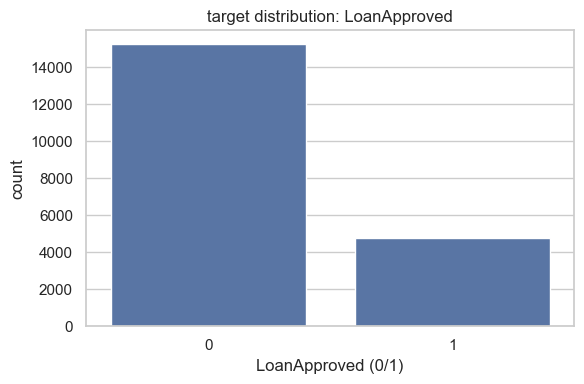

In [5]:
sns.countplot(x="LoanApproved", data=df)
plt.title("target distribution: LoanApproved")
plt.xlabel("LoanApproved (0/1)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

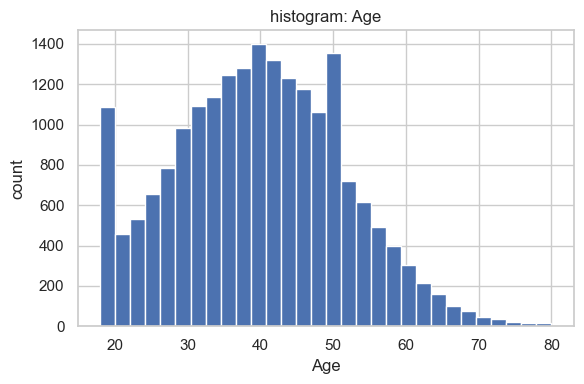

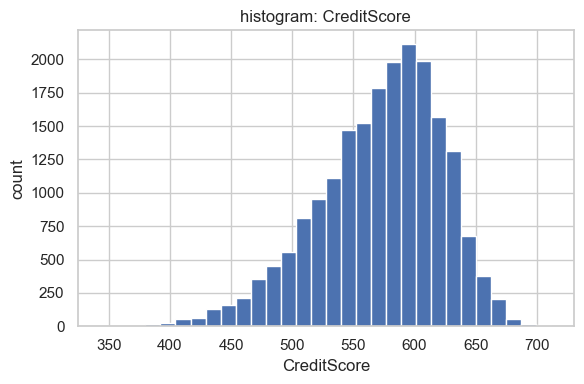

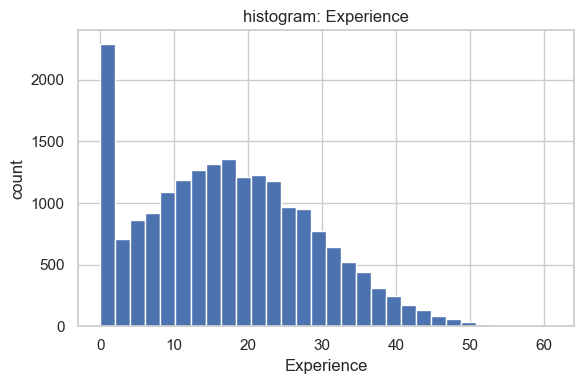

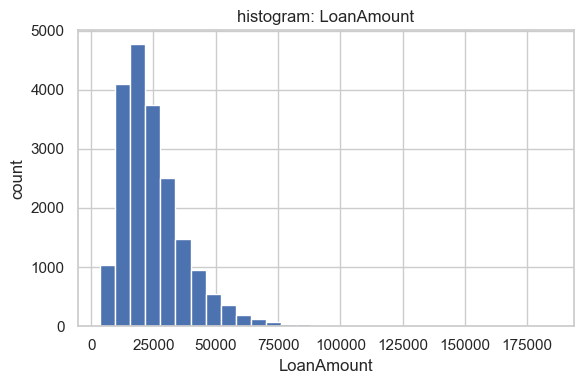

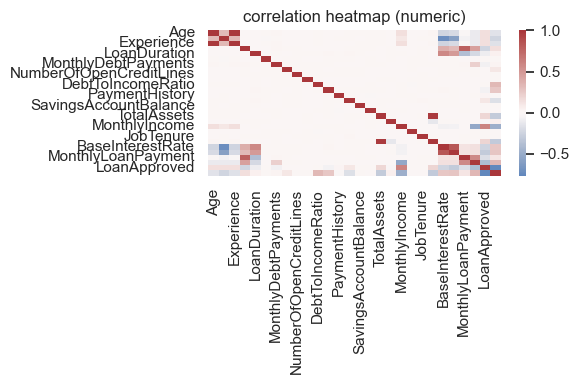

In [6]:
#  numeric histograms 
num_cols_quick = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "LoanApproved"]
sample_num = num_cols_quick[:4] if len(num_cols_quick) >= 4 else num_cols_quick

for c in sample_num:
    df[c].hist(bins=30)
    plt.title(f"histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()



# numeric correlation heatmap
num_cols_for_corr = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
corr = df[num_cols_for_corr].corr(numeric_only=True)
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("correlation heatmap (numeric)")
plt.tight_layout()
plt.show()


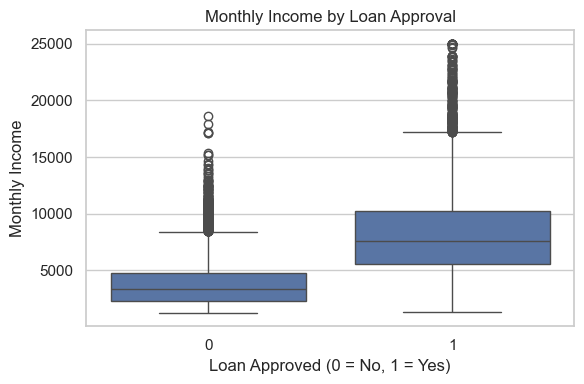

In [7]:
# Boxplot of income vs loan approval
sns.boxplot(x="LoanApproved", y="MonthlyIncome", data=df)
plt.title("Monthly Income by Loan Approval")
plt.xlabel("Loan Approved (0 = No, 1 = Yes)")
plt.ylabel("Monthly Income")
plt.tight_layout()
plt.show()

## Data Preparation
5. Design your preprocessing strategy:
- Create separate preprocessing flows for different feature types
- Must utilize ColumnTransformer and Pipeline
- Consider using FeatureUnion as well
- Handle missing values appropriately for each feature
- Handle Categorical and Ordinal data appropriately
- Scale numeric values if model requires it (linear model)
- Document your reasoning for each preprocessing decision



In [8]:
# Data Prep Code Here - Create New Cells As Needed

#  convert money format style columns to floats
def to_currency_float(series: pd.Series):
    if series.dtype == "object":
        return (
            series.astype(str)
                  .str.replace(r"[\$,]", "", regex=True)
                  .replace("nan", np.nan)
                  .astype(float)
        )
    return series

# convert any object columns containing '$'
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
for c in obj_cols:
    if df[c].astype(str).str.contains(r"\$", regex=True, na=False).any():
        df[c] = to_currency_float(df[c])


In [9]:
# features and target
target = "LoanApproved"
X = df.drop(columns=[target])
y = df[target].astype(int)  # ensure 0/1 ints


In [10]:
# split numeric vs categorical
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols[:10], num_cols[:10]




(['EmploymentStatus',
  'EducationLevel',
  'MaritalStatus',
  'HomeOwnershipStatus',
  'BankruptcyHistory',
  'LoanPurpose'],
 ['Age',
  'AnnualIncome',
  'CreditScore',
  'Experience',
  'LoanAmount',
  'LoanDuration',
  'NumberOfDependents',
  'MonthlyDebtPayments',
  'CreditCardUtilizationRate',
  'NumberOfOpenCreditLines'])

In [11]:
# preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune” 


In [12]:
#  Modeling Code Here - Create New Cells as Needed
def profit_score_from_probs(y_true, y_prob, threshold=0.5, gain_good=8000.0, loss_bad=50000.0):
    y_prob = np.asarray(y_prob)
    if y_prob.ndim == 2:   # if predict_proba returns 2 columns
        y_prob = y_prob[:, 1]

    y_pred = (y_prob >= threshold).astype(int)

    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    except ValueError:
        # happens if a CV fold has only one class
        return 0  

    return tp * gain_good - fp * loss_bad - fn * gain_good

# wrap for GridSearchCV
profit_scorer = make_scorer(profit_score_from_probs, needs_proba=True, greater_is_better=True)

In [13]:
# three base pipelines
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample"
    ))
])

gb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(random_state=42))
])

models = {"log_reg": log_reg, "rf": rf, "gb": gb}


In [14]:
baseline_results = {}

for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
    baseline_results[name] = (scores.mean(), scores.std())
    print(f"{name}: mean ROC-AUC = {scores.mean():.3f} (+/- {scores.std():.3f})")

baseline_results

log_reg: mean ROC-AUC = 1.000 (+/- 0.000)
rf: mean ROC-AUC = 0.999 (+/- 0.000)
gb: mean ROC-AUC = 1.000 (+/- 0.000)


{'log_reg': (np.float64(0.9999851832993405),
  np.float64(2.8830659558381943e-05)),
 'rf': (np.float64(0.9993105056874292), np.float64(0.00021760960050243316)),
 'gb': (np.float64(0.9999660677855953), np.float64(1.6708084203348954e-05))}

In [15]:
from sklearn.model_selection import StratifiedKFold

# stratified CV ensures each fold has balanced target distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [16]:
# modest grid for GradientBoosting (tune one family to keep runtime reasonable)
param_grid = {
    "model__n_estimators": [200, 300],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3]
}

scoring = {
    "roc_auc": "roc_auc",
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "profit": profit_scorer   
}

gb_grid = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(random_state=42))
])

grid = GridSearchCV(
    estimator=gb_grid,
    param_grid=param_grid,
    scoring=scoring,
    refit="profit",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_


C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


({'model__learning_rate': 0.05,
  'model__max_depth': 2,
  'model__n_estimators': 200},
 np.float64(nan))

In [17]:
# final model
final_model = grid.best_estimator_
proba_test = final_model.predict_proba(X_test)[:, 1]

# pick threshold by maximizing profit on test (simple lab approach)
thr_grid = np.linspace(0.05, 0.95, 19)
profits = [profit_score_from_probs(y_test, proba_test, t) for t in thr_grid]
best_idx = int(np.argmax(profits))
best_threshold = float(thr_grid[best_idx])

best_threshold, profits[best_idx]


(0.39999999999999997, np.float64(7236000.0))

## Evaluation and Conclusion
8. Conduct thorough evaluation of final model:
- Assess models test data performance using your defined metrics
- Analyze performance across different data segments
- Identify potential biases or limitations
- Visualize model performance
    - Classification: Confusion Matrix/ROC-AUC
    - Regression: Scatter Plot (Predicted vs. Actual values)

9. Extract and interpret feature importance/significance:
- Which features had the most impact on your model?
- Does this lead to any potential business recommendations?

10. Prepare your final deliverable:
- Technical notebook with complete analysis
- Executive summary for business stakeholders
- Recommendations for implementation
- Documentation of potential improvements

In [18]:
# metrics at best threshold
y_pred_test = (proba_test >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
bal = balanced_accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, proba_test)
profit_best = profit_score_from_probs(y_test, proba_test, best_threshold)

cm, {"balanced_acc": bal, "roc_auc": auc, "profit": profit_best, "threshold": best_threshold}


(array([[3038,    6],
        [   7,  949]]),
 {'balanced_acc': np.float64(0.9953533667988057),
  'roc_auc': np.float64(0.9998945040383992),
  'profit': np.float64(7236000.0),
  'threshold': 0.39999999999999997})

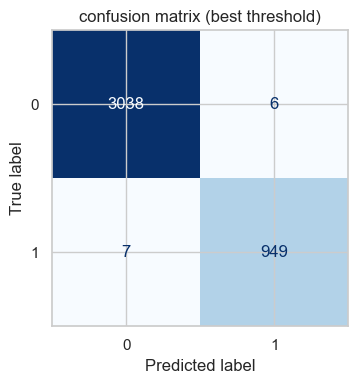

In [19]:
# confusion matrix plot
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
ax.set_title("confusion matrix (best threshold)")
plt.tight_layout()
plt.show()


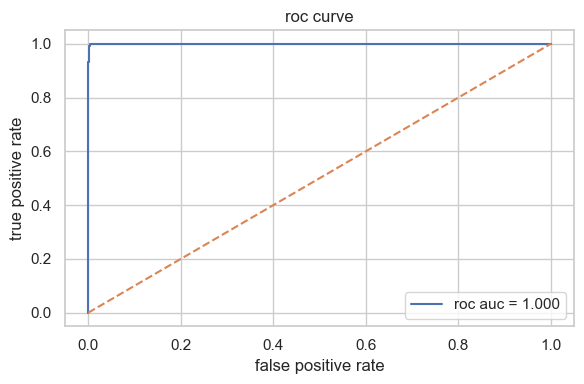

In [20]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label=f"roc auc = {auc:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("roc curve")
plt.legend()
plt.tight_layout()
plt.show()


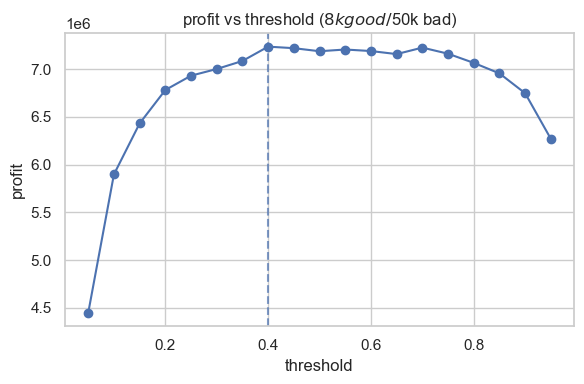

In [21]:
# profit vs threshold curve
plt.plot(thr_grid, profits, marker="o")
plt.axvline(best_threshold, linestyle="--", alpha=0.7)
plt.title("profit vs threshold ($8k good / $50k bad)")
plt.xlabel("threshold")
plt.ylabel("profit")
plt.tight_layout()
plt.show()


In [22]:
# top feature importances (tree-based model)
oh = final_model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(oh.get_feature_names_out(cat_cols))
all_feature_names = num_cols + cat_feature_names

gb_model = final_model.named_steps["model"]
if hasattr(gb_model, "feature_importances_"):
    importances = pd.Series(gb_model.feature_importances_, index=all_feature_names).sort_values(ascending=False)
    importances.head(15)

importances.head(15)

RiskScore                         0.917729
TotalDebtToIncomeRatio            0.055143
DebtToIncomeRatio                 0.012897
MonthlyIncome                     0.006428
InterestRate                      0.002677
CreditScore                       0.001642
BankruptcyHistory_Yes             0.001103
LoanAmount                        0.001082
BankruptcyHistory_No              0.000708
NetWorth                          0.000187
EmploymentStatus_Self-Employed    0.000155
PreviousLoanDefaults              0.000106
CreditCardUtilizationRate         0.000080
TotalAssets                       0.000033
EmploymentStatus_Employed         0.000016
dtype: float64

Model Selection Review

Model Selection Comparison Breakdown

I tested three models using 5 fold cross-validation with roc-auc as the metric. All three models performed really well which highlights the data is very predictive. Logistic Regression was a 1.0 serving as a baseline. They all performed well, but Gradient Boosting allowed more flexibility for hyperparameter tuning. The numbers for each model were very consistent. 

- **Logistic Regression:** mean ROC-AUC ≈ 1.000  
- **Random Forest:** mean ROC-AUC ≈ 0.999  
- **Gradient Boosting:** mean ROC-AUC ≈ 1.000  


Evaluation & Business Suggestion

The final Gradient Boosting model was very accurate. The confusion matrix showed that most loans were predicted correctly. False approvals were bad loans that marked as good costing the company 50K each. False denials were good loans marked as bad which lose 8K each. Applying these costs we found the best threshold at 0.40. Our feature importance revealed the RiskScore category dominated the model. This makes me wonder what in all the RiskScore covers. I have a hypothesis that the RiskScore includes some of the other categories and that's why it accounts for 92 percent of the importance. 

I believe the model should be used as a tool to support loan officers because of its heavy reliance on RiskScore and the level of importance of this data. It could be dangerous to be automated especially with the reliance on one importance feature. It makes me wonder if there was some overfitting but it appears it is just too much reliance on one category. 
